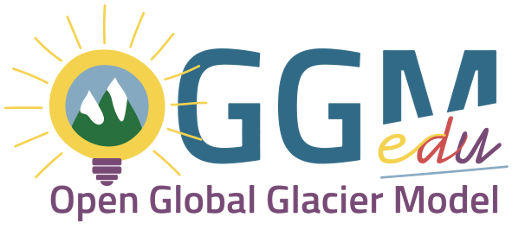

# Getting started with flowline models: idealized experiments

In this notebook we are going to explore the basic functionalities of OGGM flowline model(s). For this purpose we are going to use simple and "idealized" glaciers models and compute them with simple linear mass balance profiles. 

In [1]:
# import oggm-edu helper package
import oggm_edu as edu

In [2]:
# import modules, constants and set plotting defaults
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9, 6)  # Default plot size

# Scientific packages
import numpy as np

# Constants
from oggm import cfg
cfg.initialize_minimal()

# OGGM models
from oggm.core.massbalance import LinearMassBalance
from oggm.core.flowline import FluxBasedModel, RectangularBedFlowline, TrapezoidalBedFlowline, ParabolicBedFlowline

# There are several numerical implementations in OGGM core. We use the "FluxBasedModel"
FlowlineModel = FluxBasedModel

2021-03-11 16:59:59: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-03-11 16:59:59: oggm.cfg: Multiprocessing switched OFF according to the ENV variable OGGM_USE_MULTIPROCESSING
2021-03-11 16:59:59: oggm.cfg: Multiprocessing: using slurm allocated processors (N=1)


## Basics

First we set-up a simple run with a constant linear bedrock:

### Glacier bed

In [3]:
# define horizontal resolution of the model:
# nx: number of grid points
# map_dx: grid point spacing in meters
nx = 400
map_dx = 100

In [4]:
# define glacier top and bottom altitudes in meters
top = 3400
bottom = 3400

In [5]:
# create a linear bedrock profile from top to bottom
bed_h, surface_h = edu.define_linear_bed(top, bottom, nx)

In [6]:
# calculate the distance from the top to the bottom of the glacier in km
distance_along_glacier = edu.distance_along_glacier(nx, map_dx)

In [7]:
bed_h = bed_h.copy()

We'll start with a roundish blob of ice.

In [8]:
surface_h[:100] = bed_h[:100] + 50*np.sqrt(100 - distance_along_glacier[:100]**2)

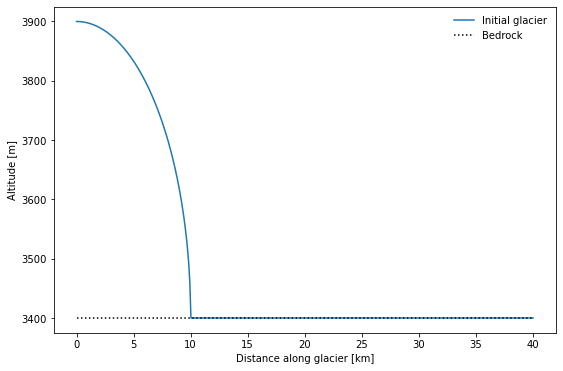

In [9]:
# plot the glacier bedrock profile and the initial glacier surface
plt.plot(distance_along_glacier, surface_h, label='Initial glacier')
edu.plot_xz_bed(x=distance_along_glacier, bed=bed_h);

Now we have to decide how wide our glacier is, and what the *shape* of its bed is. For a start, we will use a rectangular "u-shaped" bed (see the [documentation](http://docs.oggm.org/en/latest/ice-dynamics.html#rectangular)), with a constant width of 300m:

In [10]:
initial_width = 300 #width in meters
# Now describe the widths in "grid points" for the model, based on grid point spacing map_dx
widths = np.zeros(nx) + initial_width/map_dx
# Define our bed
init_flowline = RectangularBedFlowline(surface_h=surface_h, bed_h=bed_h, widths=widths, map_dx=map_dx)

The init_flowline variable now contains all geometrical information needed by the model. It can give access to some attributes, which are quite useless for a non-existing glacier: 

In [11]:
print('Glacier length:', init_flowline.length_m)
print('Glacier area:', init_flowline.area_km2)
print('Glacier volume:', init_flowline.volume_km3)

Glacier length: 10000.0
Glacier area: 3.0
Glacier volume: 1.1825514951817964


### Mass balance

Then we will need a mass balance model. In our case this will be zero, because we're looking at how a lump of ice deforms under it's own weight. We should, we hope, see that the volume of ice doesn't change over time:

In [12]:
# ELA at 3000m a.s.l., gradient 4 mm m-1
ELA = 3400 #equilibrium line altitude in meters above sea level
altgrad = 0 #altitude gradient in mm/m
mb_model = LinearMassBalance(ELA, grad=altgrad)

### Model run

Now that we have all the ingredients to run the model, we just have to initialize it:

In [13]:
# The model requires the initial glacier bed, a mass balance model, and an initial time (the year y0)
model = FlowlineModel(init_flowline, mb_model=mb_model, y0=0.)

Let's first run the model for one year:

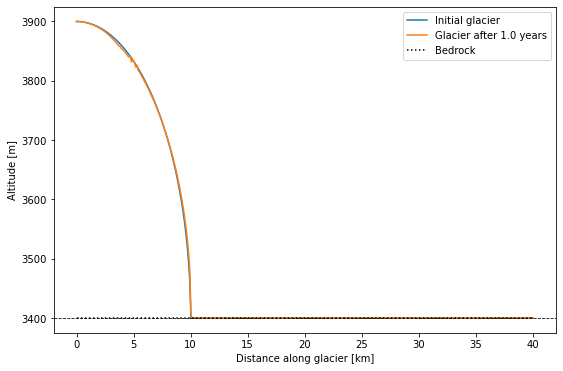

In [14]:
runtime = 1
model.run_until(runtime)
edu.glacier_plot(x=distance_along_glacier, bed=bed_h, model=model, mb_model=mb_model, init_flowline=init_flowline)

What can you see? Not much? Let's print some things out.

In [15]:
print('Year:', model.yr)
print('Glacier length (m):', model.length_m)
print('Glacier area (km2):', model.area_km2)
print('Glacier volume (km3):', model.volume_km3)

Year: 1.0
Glacier length (m): 10300.0
Glacier area (km2): 3.09
Glacier volume (km3): 1.1825514951817961


**Q1** How has the glacier changed since the initial state? Has the glacier's volume actually been conserved? Explain why / why not.

We can now run the model for 150 years and see how the output looks like:

In [ ]:
runtime = 150
model.run_until(runtime)
edu.glacier_plot(x=distance_along_glacier, bed=bed_h, model=model, mb_model=mb_model, init_flowline=init_flowline)

Let's print out a few infos about our glacier:

In [ ]:
print('Year:', model.yr)
print('Glacier length (m):', model.length_m)
print('Glacier area (km2):', model.area_km2)
print('Glacier volume (km3):', model.volume_km3)

Note that the model time is now 150 years. Running the model with the same input again, calls the already calculated results but does not execute the method `model.run_until` another time, which safes computational time. 



In [ ]:
model.run_until(150)
print('Year:', model.yr)
print('Glacier length (m):', model.length_m)

If we want to compute longer, we have to set the desired date. Hereby, the model computes only the additional missing years.

In [ ]:
runtime = 500
model.run_until(runtime)
edu.glacier_plot(x=distance_along_glacier, bed=bed_h, model=model, mb_model=mb_model, init_flowline=init_flowline)

In [ ]:
print('Year:', model.yr)
print('Glacier length (m):', model.length_m)
print('Glacier area (km2):', model.area_km2)
print('Glacier volume (km3):', model.volume_km3)

However, it is important to note, that the model will not calculate back in time.
Once calculated for 500 years, the model will not run again for 450 years and remains at 500 years.  Try running the cell below.  Does the output match what you expected?

In [ ]:
model.run_until(450)
print('Year:', model.yr)
print('Glacier length (m):', model.length_m)

It might be useful to store some intermediate steps of the evolution of the glacier.  We make a loop so that the model reports to us several times.

In [ ]:
# Reinitialize the model
model = FlowlineModel(init_flowline, mb_model=mb_model, y0=0.)
# Year 0 to 10000 in 10 years step
yrs = np.arange(0, 10001, 10) 
# Array to fill with data
nsteps = len(yrs)
length = np.zeros(nsteps)
vol = np.zeros(nsteps)
# Loop
for i, yr in enumerate(yrs):
    model.run_until(yr)
    length[i] = model.length_m
    vol[i] = model.volume_km3
# I store the final results for later use
flat_glacier_h = model.fls[-1].surface_h

We can now plot the evolution of the glacier length and volume with time:

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(yrs, length);
ax1.set_xlabel('Years')
ax1.set_ylabel('Length (m)');
ax2.plot(yrs, vol);
ax2.set_xlabel('Years')
ax2.set_ylabel('Volume (km3)');

**Q2** How does the glacier's length change over time? Is it constant? linear? accelerating? decelerating? Can you explain the pattern of the glacier's extension by referring to the rheology of ice?

**Q3** Having seen now 10,000 years of the model's volume, how did the code do in mass conservtion?

## Adding a slope

We can now add a slope to the glacier to see how flowing downhill changes things. We'll make the bottom 1 km lower than the top, but keep the same initial thickness profile.

In [ ]:
# define glacier top and bottom altitudes in meters
top = 3400
bottom = 2400
# create a linear bedrock profile from top to bottom
bed_h_slope, surface_h_slope = edu.define_linear_bed(top, bottom, nx)
bed_h_slope = bed_h_slope.copy()
surface_h_slope[:100] = bed_h_slope[:100] + 50*np.sqrt(100 - distance_along_glacier[:100]**2)

In [ ]:
# plot the glacier bedrock profile and the initial glacier surface
plt.plot(distance_along_glacier, surface_h_slope, label='Initial glacier')
edu.plot_xz_bed(x=distance_along_glacier, bed=bed_h_slope);

We'll perform the same time loop as we did for the flat glacier, making sure to save things to nbew variables so that we can compare them. But first:

**Q4** What do you expect will happen? Will the glacier flowing downhill extend faster or slower? Why?

In [ ]:
# Reinitialize the model
slope_flowline = RectangularBedFlowline(surface_h=surface_h_slope, bed_h=bed_h_slope, widths=widths, map_dx=map_dx)
model = FlowlineModel(slope_flowline, mb_model=mb_model, y0=0.)
# Year 0 to 10000 in 10 years step
yrs = np.arange(0, 10001, 10) 
# Array to fill with data
nsteps = len(yrs)
length_slope = np.zeros(nsteps)
vol_slope = np.zeros(nsteps)
# Loop
for i, yr in enumerate(yrs):
    model.run_until(yr)
    length_slope[i] = model.length_m
    vol_slope[i] = model.volume_km3
# I store the final results for later use
slope_glacier_h = model.fls[-1].surface_h

In [ ]:
edu.glacier_plot(x=distance_along_glacier, bed=bed_h_slope, model=model, mb_model=mb_model, init_flowline=slope_flowline)

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(yrs, length, label='Flat bed');
ax1.plot(yrs, length_slope, label='Sloped bed');
ax1.set_xlabel('Years')
ax1.set_ylabel('Length (m)');
ax1.legend()
ax2.plot(yrs, vol);
ax2.plot(yrs, vol_slope);
ax2.set_xlabel('Years')
ax2.set_ylabel('Volume (km3)');

**Q5** Revaluate your expectations. Was your hypothesis borne out by the model?

## Temperature

We start with the internal deformation which results in creeping of a glacier. To describe it we use Glens's creep parameter. The default in OGGM is to set Glen's creep parameter `A` to the "standard value" defined by Cuffey and Paterson[¹](#References).

The parameter relates shear stress to the rate of deformation and is assumed to be constant. It depends on crystal size, fabric, concentration and type of impurities, as well as on ice temperature[²](#References)
(you can find a more detailed description of it [here](http://www.antarcticglaciers.org/modern-glaciers/glacier-flow-2/glacier-flow-ii-stress-and-strain/)). In the following we will change it and see what happens.

Therefore we have to define the bedrock and a grid. (We do similiar steps like in [flowline_model](http://edu.oggm.org/en/latest/notebooks_flowline_intro.html#glacier-flowline-modelling) to generate a set-up for our experiment.)

In [ ]:
# Glenn flow parameter
A_big = cfg.PARAMS['glen_a'] * 5

# Reinitialize the model
warm_flowline = RectangularBedFlowline(surface_h=surface_h_slope, bed_h=bed_h_slope, widths=widths, map_dx=map_dx)
model = FlowlineModel(warm_flowline, mb_model=mb_model, y0=0., glen_a=A_big)
# Year 0 to 10000 in 10 years step
yrs = np.arange(0, 10001, 10) 
# Array to fill with data
nsteps = len(yrs)
length_warm = np.zeros(nsteps)
vol_warm = np.zeros(nsteps)
# Loop
for i, yr in enumerate(yrs):
    model.run_until(yr)
    length_warm[i] = model.length_m
    vol_warm[i] = model.volume_km3
# I store the final results for later use
warm_glacier_h = model.fls[-1].surface_h

**Q6** Before plotting the result, try to hypothesize what the result will be in terms of length and thickness.

In [ ]:
edu.glacier_plot(x=distance_along_glacier, bed=bed_h_slope, model=model, mb_model=mb_model, init_flowline=warm_flowline)

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(yrs, length, label='Flat bed');
ax1.plot(yrs, length_slope, label='Sloped bed');
ax1.plot(yrs, length_warm, label='Warm ice');
ax1.set_xlabel('Years')
ax1.set_ylabel('Length (m)');
ax1.legend()
ax2.plot(yrs, vol);
ax2.plot(yrs, vol_slope);
ax2.plot(yrs, vol_warm);
ax2.set_xlabel('Years')
ax2.set_ylabel('Volume (km3)');

## Sliding
Basal sliding occurs when there is a water film between the ice and the ground. In his [seminal paper](https://www.igsoc.org/annals/24/igs_annals_vol24_year1997_pg382-389.pdf), Hans Oerlemans uses a so-called "sliding parameter" (here: fs), representing basal sliding. In OGGM this parameter is set to 0 per default, but it can be modified:

In [ ]:
# Sliding parameter
fs = 5.7e-20

# Reinitialize the model
slide_flowline = RectangularBedFlowline(surface_h=surface_h_slope, bed_h=bed_h_slope, widths=widths, map_dx=map_dx)
model = FlowlineModel(slide_flowline, mb_model=mb_model, y0=0., fs=fs)
# Year 0 to 10000 in 10 years step
yrs = np.arange(0, 10001, 10) 
# Array to fill with data
nsteps = len(yrs)
length_slide = np.zeros(nsteps)
vol_slide = np.zeros(nsteps)
# Loop
for i, yr in enumerate(yrs):
    model.run_until(yr)
    length_slide[i] = model.length_m
    vol_slide[i] = model.volume_km3
# I store the final results for later use
slide_glacier_h = model.fls[-1].surface_h

**Q7** Before plotting the result, try to hypothesize what the result will be in terms of length and thickness.

In [ ]:
edu.glacier_plot(x=distance_along_glacier, bed=bed_h_slope, model=model, mb_model=mb_model, init_flowline=slope_flowline)

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(yrs, length, label='Flat bed');
ax1.plot(yrs, length_slope, label='Sloped bed');
ax1.plot(yrs, length_warm, label='Warm ice');
ax1.plot(yrs, length_slide, label='Sliding bed');
ax1.set_xlabel('Years')
ax1.set_ylabel('Length (m)');
ax1.legend()
ax2.plot(yrs, vol);
ax2.plot(yrs, vol_slope);
ax2.plot(yrs, vol_warm);
ax2.plot(yrs, vol_slide);
ax2.set_xlabel('Years')
ax2.set_ylabel('Volume (km3)');

We can, finally plot all these glacier thickness together to see how the thickness profiles depend on things like slope of bedrock, temperature of ice, and sliding at the bed.

In [ ]:
# Plot the final result:
plt.plot(distance_along_glacier, simple_glacier_h-bed_h, label='Flat glacier')
plt.plot(distance_along_glacier, slope_glacier_h-bed_h_slope, label='Sloped glacier')
plt.plot(distance_along_glacier, warm_glacier_h-bed_h_slope, label='Sloped+warm glacier')
plt.plot(distance_along_glacier, slide_glacier_h-bed_h_slope, label='Sloped+sliding glacier')
plt.legend()
plt.title('Glacier Thicknesses after 10,000 years');

**Q8** Describe how the thicknesses with different temperatures and basal friction differ from each other visually.

**Explore** Now play around with things and make some predictions. Definitely copy and paste code, but make sure to save variables under different names so you can plot them together.

## Unfinished: Stress / Strain
OGGM computes the velocities, which can be accessed in ```model.u_stag[0]``` (```[0]``` because the velocity is a vector with 2 components in this 2D model,

In [ ]:
plt.plot(distance_along_glacier, model.u_stag[0][1:])

## References

¹ Cuffey, K., and W. S. B. Paterson (2010). The Physics of Glaciers, Butterworth‐Heinemann, Oxford, U.K.

² Oerlemans, J. (2001). *Glaciers and climate change.* CRC Press. (p. 59)